## Introduction

## NLP and Sentiment Analysis

When you have unstructured data it is useful to categorize it using sentiment analysis. This type of analysis allows you to assign value to texts, sentences and/or headlines. For this project I thought it useful to take financial headlines from news organizations and see if I could reduce the headlines down to a binary product. This means assigning a number to a headline to distinguish it as a negative, positive, or neutral headline; categorizing the sentiment. This is done to be a basis of exploring further headlines and their relations to stock performance. Is it be possible to see how much headlines affect the price of a stock?

#### Dataset:
[Sentiment Analysis for Financial News-Kaggle](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

[Bloomberg Financial Headlines -Scraped](https://rapidapi.com/apidojo/api/bloomberg-market-and-financial-news/endpoints)

## Libraries

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [128]:
#import and check version of tensorflow
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [131]:
# import and look at data imported from kaggle
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  negative   
1  neutral    
2  positive   
3  neutral    
4  positive   

                                                                                                                                                                                                                                                                   Headline  
0  In Q1 of 2009 , Bank of +_land 's net interest income weakened by 10 % to EUR 9.1 mn .                                                                                                                                                                                    
1  Following the move , Stora Enso holding in NewPage will remain unchanged .                                                                                                                                                                                                
2  com , and we are constantly planning new ways to serve our customers online on a more comprehensive basis , '' says Matti Leminen , President of Anttila Oy .                                                                                                             
3  ALEXANDRIA , Va. , March 20 -- Patrik Flykt and Timo Alakoski , both of Helsinki , Finland , and Tapio Suihko and Nadarajah Asokan , both of Espoo , Finland , have developed a method of mobility support of Internet-type protocol traffic in a communication system .  
4  Operating profit was EUR 11.4 mn , up from EUR 7.5 mn .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [132]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

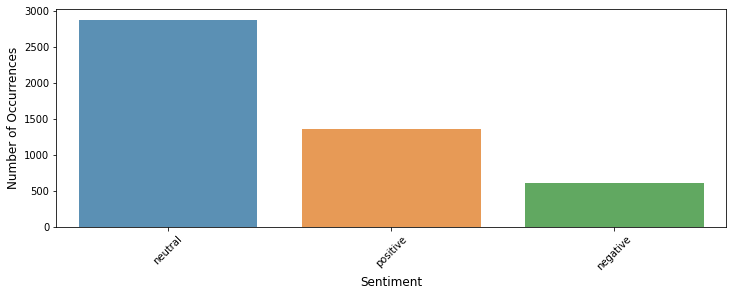

In [133]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [134]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [135]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  2           
1  1           
2  0           
3  1           
4  0           
5  1           
6  0           
7  1           
8  1           
9  1           

                                                                                                                                                                                                                                                                   Headline  
0  In Q1 of 2009 , Bank of +_land 's net interest income weakened by 10 % to EUR 9.1 mn .                                                                                                                                                                                    
1  Following the move , Stora Enso holding in NewPage will remain unchanged .                                                                                                                                                                                                
2  com , and we are constantly planning new ways to serve our customers online on a more comprehensive basis , '' says Matti Leminen , President of Anttila Oy .                                                                                                             
3  ALEXANDRIA , Va. , March 20 -- Patrik Flykt and Timo Alakoski , both of Helsinki , Finland , and Tapio Suihko and Nadarajah Asokan , both of Espoo , Finland , have developed a method of mobility support of Internet-type protocol traffic in a communication system .  
4  Operating profit was EUR 11.4 mn , up from EUR 7.5 mn .                                                                                                                                                                                                                   
5  The prerequisite for inclusion in the program and for receipt of any gains is that key employees acquire Aspo shares to the amount determined by the Board in advance , in the maximum .                                                                                  
6  Operating profit was EUR 139.7 mn , up 23 % from EUR 113.8 mn .                                                                                                                                                                                                           
7  In 2010 , the Marimekko Group s net sales were EUR 73,297 thousand ( EUR 72,473 thousand ) and operating profit was EUR 8,169 thousand ( EUR 6,291 thousand ) .                                                                                                           
8  SHARE REPURCHASE 11.01.2008 In the Helsinki Stock Exchange On behalf of Sampo plc Danske Bank A-S Helsinki Branch                                                                                                                                                         
9  The deal will have no significant effect on the acquiring company 's equity ratio .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [136]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [137]:
#make a new column for clean headlines and then other columns for different version of data

In [138]:
#check
df.head()

Sentiment  \
0  2           
1  1           
2  0           
3  1           
4  0           

                                                                                                                                                                                                   Headline  
0  q1 2009 bank +_land net interest income weakened 10 eur 9.1 mn                                                                                                                                            
1  following move stora enso holding newpage remain unchanged                                                                                                                                                
2  com constantly planning new ways serve customers online comprehensive basis '' says matti leminen president anttila oy                                                                                    
3  alexandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system  
4  operating profit eur 11.4 mn eur 7.5 mn

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [139]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [140]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [141]:
#check
df.head()

Sentiment  \
0  2           
1  1           
2  0           
3  1           
4  0           

                                                                                                                                                                                                   Headline  \
0  q1 2009 bank +_land net interest income weakened 10 eur 9.1 mn                                                                                                                                             
1  following move stora enso holding newpage remain unchanged                                                                                                                                                 
2  com constantly planning new ways serve customers online comprehensive basis '' says matti leminen president anttila oy                                                                                     
3  alexandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system   
4  operating profit eur 11.4 mn eur 7.5 mn                                                                                                                                                                    

                                                                                                                                                                                             Headline_Lemma  
0  q1 2009 bank +_land net interest income weaken 10 eur 9.1 mn                                                                                                                                              
1  follow move stora enso hold newpage remain unchanged                                                                                                                                                      
2  com constantly planning new way serve customer online comprehensive basis '' say matti leminen president anttila oy                                                                                       
3  alexandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system  
4  operating profit eur 11.4 mn eur 7.5 mn

WordCloud to see the commonly used words

In [142]:
#!pip install wordcloud

In [143]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [144]:
def wordcloud(dataset):
    '''Wordcloud for the dataset'''
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


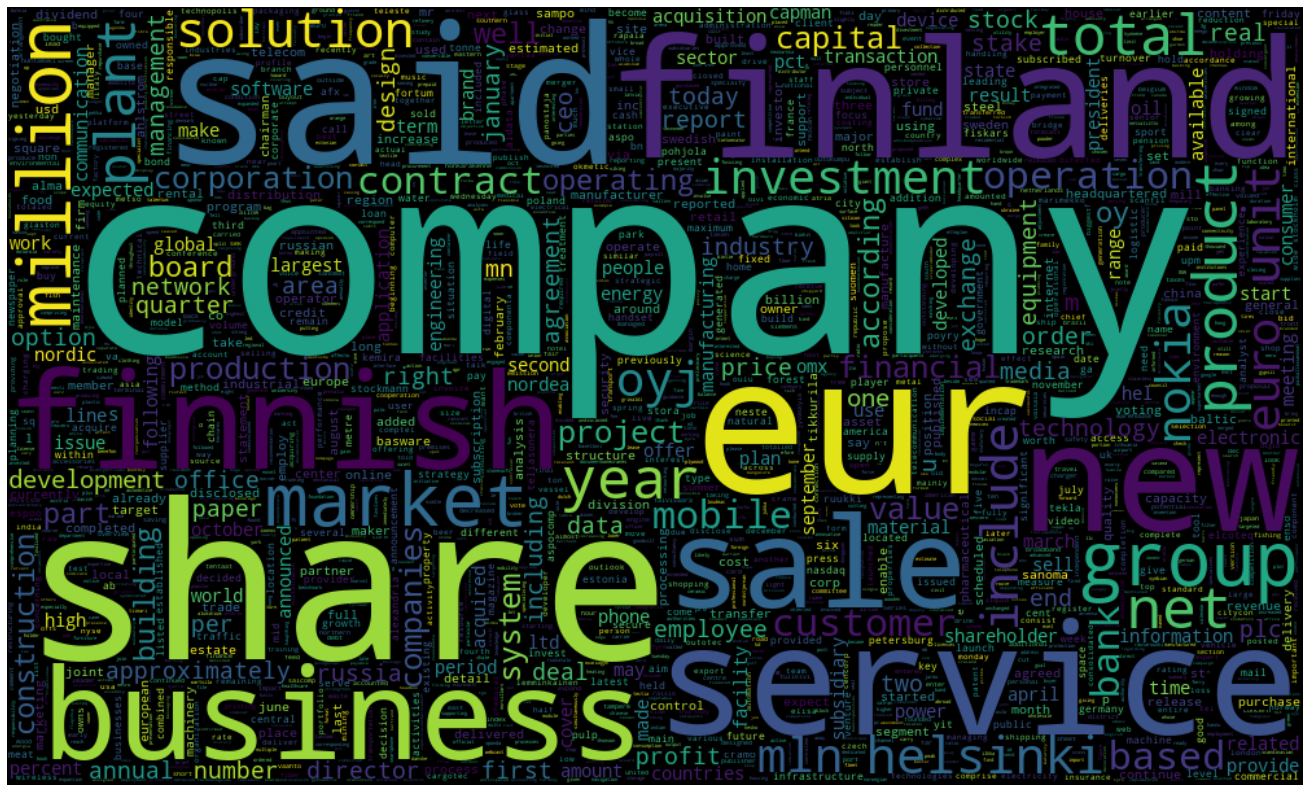

Negative Sentiment Wordcloud:


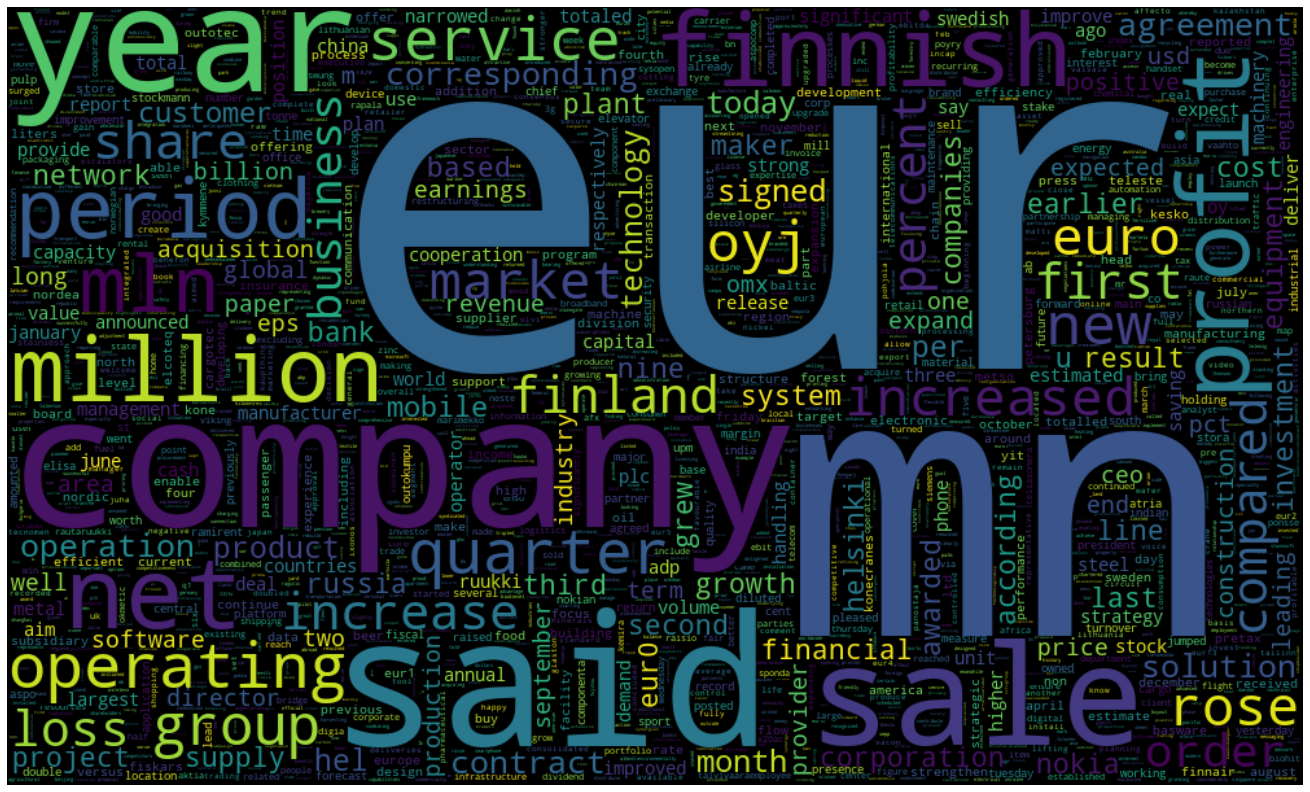

In [145]:
show_wordclouds()

Positive Sentiment Wordcloud:


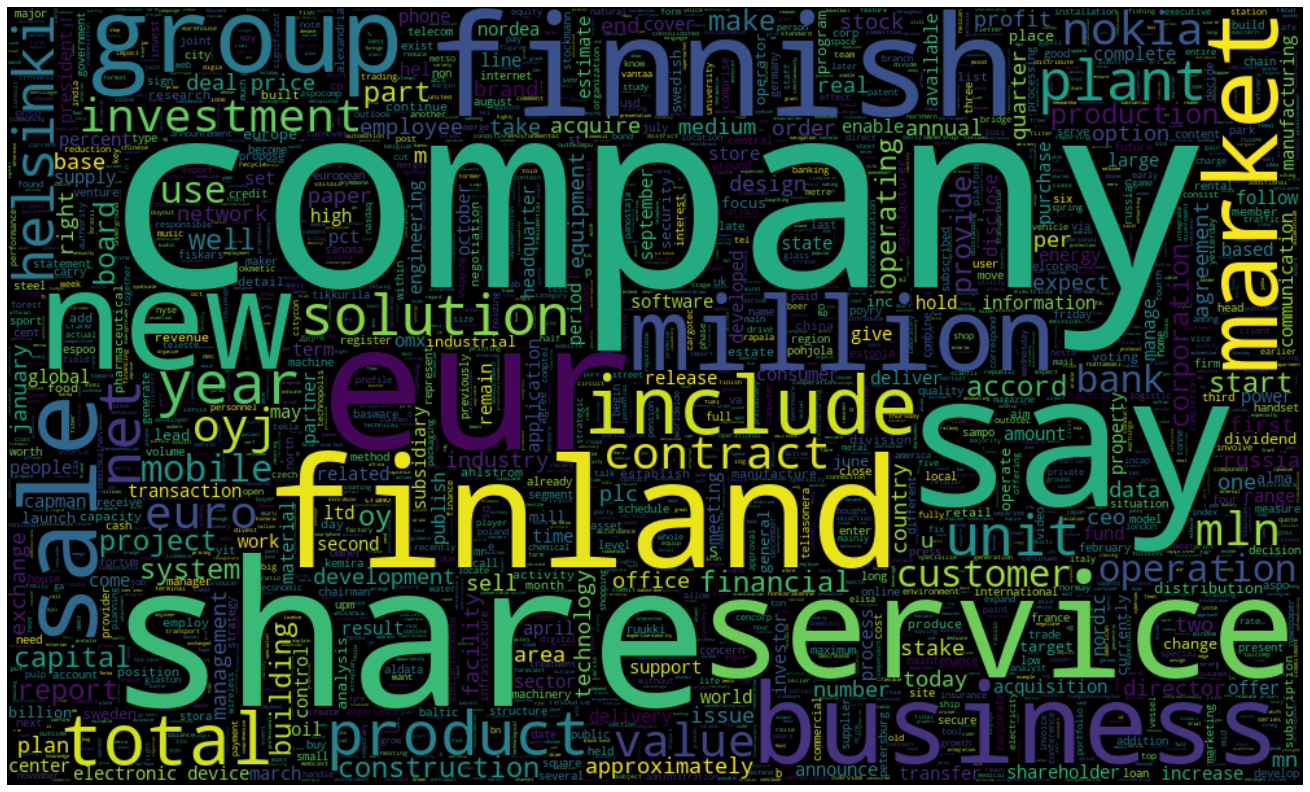

Negative Sentiment Wordcloud:


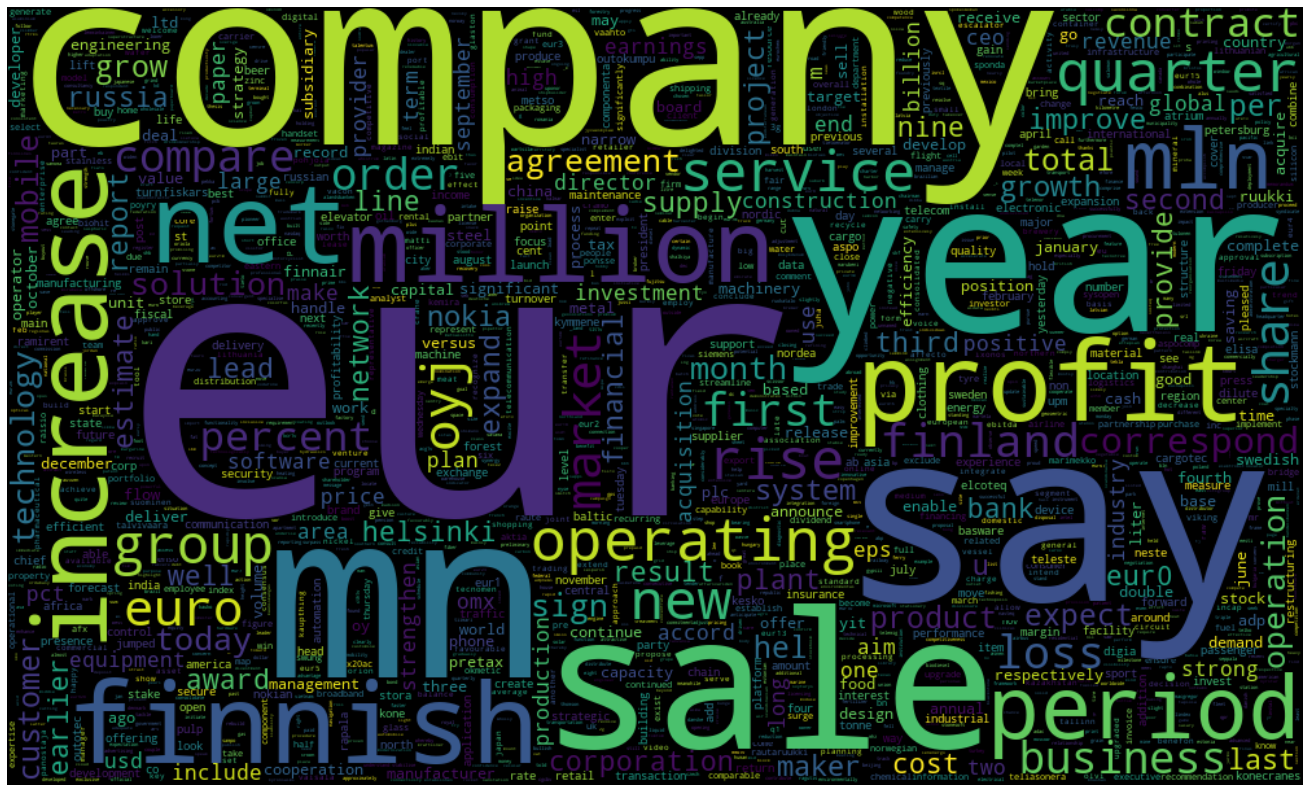

In [146]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [147]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [148]:
df.head()

Sentiment  \
0  2           
1  1           
2  0           
3  1           
4  0           

                                                                                                                                                                                                   Headline  \
0  q1 2009 bank +_land net interest income weakened 10 eur 9.1 mn                                                                                                                                             
1  following move stora enso holding newpage remain unchanged                                                                                                                                                 
2  com constantly planning new ways serve customers online comprehensive basis '' says matti leminen president anttila oy                                                                                     
3  alexandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system   
4  operating profit eur 11.4 mn eur 7.5 mn                                                                                                                                                                    

                                                                                                                                                                                             Headline_Lemma  \
0  q1 2009 bank +_land net interest income weaken 10 eur 9.1 mn                                                                                                                                               
1  follow move stora enso hold newpage remain unchanged                                                                                                                                                       
2  com constantly planning new way serve customer online comprehensive basis '' say matti leminen president anttila oy                                                                                        
3  alexandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system   
4  operating profit eur 11.4 mn eur 7.5 mn                                                                                                                                                                    

                                                                                                                                                                                             Headline_soup  
0  q1 2009 bank +_land net interest income weaken 10 eur 9.1 mn                                                                                                                                             
1  follow move stora enso hold newpage remain unchanged                                                                                                                                                     
2  com constantly planning new way serve customer online comprehensive basis '' say matti leminen president anttila oy                                                                                      
3  aleandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system  
4  operating profit eur 11.4 mn eur 7.5 mn

#### Counter

In [149]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [150]:
text = df.Headline_Lemma
counter = counter_word(text)

In [151]:
len(counter)

10088

In [152]:
num_words = len(counter)

### Train/Test Split

In [153]:
# headlines = []
# labels = []

# for row in range(len(df)):
#     headlines.append(df['Headline_soup'][row])
#     labels.append(df['Sentiment'][row])

In [154]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(
    df['Headline_soup'], df['Sentiment'], test_size=0.2 , random_state=42)

In [155]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [156]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

432     iggesunds bruk sweden one advanced fully integrate pulp paperboard mill world                                    
3071    apple inc. iphone wo n't change game plan verizon communication inc. chief eecutive ivan seidenberg say wednesday
289     authorization force period 18 month resolution general meeting                                                   
Name: Headline_soup, dtype: object

432     0
3071    1
289     1
Name: Sentiment, dtype: int64

In [157]:
training_labels.value_counts(normalize=1)

1    0.590299
0    0.283540
2    0.126161
Name: Sentiment, dtype: float64

In [158]:
testing_labels.value_counts(normalize=1)

1    0.609278
0    0.272165
2    0.118557
Name: Sentiment, dtype: float64

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [159]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [160]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [161]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [162]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [163]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [164]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [165]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
# training_padded = np.array(training_padded)
# training_labels = np.array(training_labels)
# testing_padded = np.array(testing_padded)
# testing_labels = np.array(testing_labels)

In [166]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19
  56 235 406 357   1  24  40   6  52  12   1 148  18   6  23]

The actual headline:
 aleandria va. march 20 -- patrik flykt timo alakoski helsinki finland tapio suihko nadarajah asokan espoo finland developed method mobility support internet-type protocol traffic communication system

Label:
 1


In [167]:
# train
#train_tagged.values

In [168]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([0., 1., 0.], dtype=float32)

### Model 1 (Hidden Layer)

In [169]:
# embedding_dim = 100

# model = Sequential()
# model.add(Embedding(num_words, embedding_dim, input_length=64))
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2)) # Optional Regularization
# model.add(Dense(3, activation='sigmoid'))

# # Slower learning rate worked better as it kept the learning more stable
# #opt = keras.optimizers.Adam(lr=0.0001)
# model.compile(loss='categorical_crossentropy',optimizer='adam', 
#               metrics=['accuracy']) # Orig code

In [170]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [171]:
#results.history.keys()

In [172]:



def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
    
def visualize_training_results(results):
    """
   1 Input: The Training and 
    Validation/Testing Dictionary 
    of Loss and Accuracy
    
    Output: 2 Plots of Loss vs. Epochs
    and Accuracy vs. Epochs
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [173]:
#model_metrics(model)

In [174]:
#test_headlines()

### Model 1 (LSTM):

In [175]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [176]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1008800   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [177]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
146/146 [==============================] - 8s 56ms/step - loss: 0.8703 - accuracy: 0.6132 - val_loss: 0.7199 - val_accuracy: 0.6546
Epoch 2/50
146/146 [==============================] - 7s 48ms/step - loss: 0.6045 - accuracy: 0.7256 - val_loss: 0.7027 - val_accuracy: 0.6881
Epoch 3/50
146/146 [==============================] - 7s 49ms/step - loss: 0.3645 - accuracy: 0.8506 - val_loss: 0.6919 - val_accuracy: 0.7113
Epoch 4/50
146/146 [==============================] - 7s 46ms/step - loss: 0.1718 - accuracy: 0.9392 - val_loss: 0.8090 - val_accuracy: 0.7268
Epoch 5/50
146/146 [==============================] - 7s 46ms/step - loss: 0.0876 - accuracy: 0.9733 - val_loss: 0.9418 - val_accuracy: 0.7242
Epoch 6/50
146/146 [==============================] - 7s 45ms/step - loss: 0.0553 - accuracy: 0.9819 - val_loss: 1.1016 - val_accuracy: 0.7397
Epoch 7/50
146/146 [==============================] - 6s 44ms/step - loss: 0.0348 - accuracy: 0.9894 - val_loss: 1.2484 - val_accuracy: 0.7294

In [178]:
# Add analysis of model

In [179]:
y_hat = model.predict(testing_padded)
predicted = y_hat.argmax(axis=1)
true = testing_labels_ohe.argmax(axis=1)

In [180]:
import sklearn.metrics as metrics

print(metrics.classification_report(true,predicted))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       264
           1       0.80      0.81      0.80       591
           2       0.58      0.54      0.56       115

    accuracy                           0.71       970
   macro avg       0.65      0.64      0.64       970
weighted avg       0.71      0.71      0.71       970



While the precision, recall and f1 score are greater than 50% I believe they can be increased by addressing a class imbalanced. This is evident with the 80% score given to the neutral (1) rating which has a far greater amount of data compared to the others.

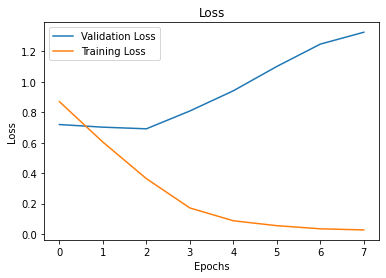

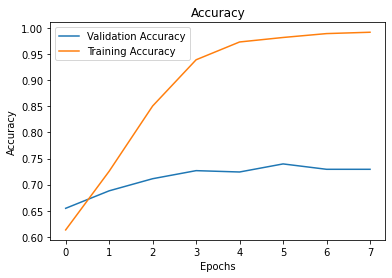

In [182]:
visualize_training_results(history)
#model_eval(history)

## Model 2

In [227]:
embedding_dim = 132

model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, input_length=max_length))
model2.add(LSTM(64, dropout = 0.1))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [228]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model2.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
109/109 [==============================] - 5s 49ms/step - loss: 0.8824 - accuracy: 0.6141 - val_loss: 0.7347 - val_accuracy: 0.6649
Epoch 2/50
109/109 [==============================] - 5s 46ms/step - loss: 0.5872 - accuracy: 0.7552 - val_loss: 0.6552 - val_accuracy: 0.7242
Epoch 3/50
109/109 [==============================] - 5s 45ms/step - loss: 0.2941 - accuracy: 0.8879 - val_loss: 0.7393 - val_accuracy: 0.7500
Epoch 4/50
109/109 [==============================] - 5s 46ms/step - loss: 0.1543 - accuracy: 0.9481 - val_loss: 0.8154 - val_accuracy: 0.7526
Epoch 5/50
109/109 [==============================] - 5s 46ms/step - loss: 0.0901 - accuracy: 0.9702 - val_loss: 1.0718 - val_accuracy: 0.7345
Epoch 6/50
109/109 [==============================] - 5s 44ms/step - loss: 0.0606 - accuracy: 0.9794 - val_loss: 1.1193 - val_accuracy: 0.7216
Epoch 7/50
109/109 [==============================] - 5s 42ms/step - loss: 0.0435 - accuracy: 0.9877 - val_loss: 1.3433 - val_accuracy: 0.7268

In [185]:
#model_metrics(model)

In [229]:
y_hat = model2.predict(testing_padded)
predicted = y_hat.argmax(axis=1)
true = testing_labels_ohe.argmax(axis=1)

In [230]:
print(metrics.classification_report(true,predicted))

ValueError: Found input variables with inconsistent numbers of samples: [970, 63]

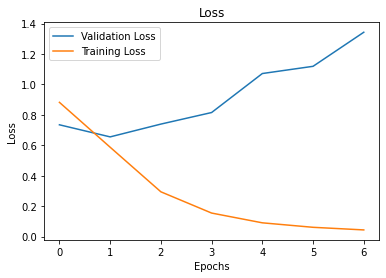

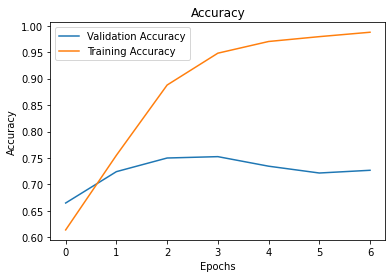

In [231]:
#model_eval(history) #seperate val and loss
visualize_training_results(history)

### Import Headlines To Test Model

import requests

url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/news/list-by-region"

querystring = {"id":"home-v3"}

headers = {
    'x-rapidapi-key': "",
    'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

In [187]:
# import requests

# url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/news/list-by-region"

# querystring = {"id":"home-v3"}

# headers = {
#     'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
#     'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
#     }

# response = requests.request("GET", url, headers=headers, params=querystring)

# print(response.text)

In [188]:
# response.json()

In [189]:
# results = response.json()
# results.keys()

In [190]:

# modules = results['modules']
# len(modules)

Loops to get more stories

In [191]:
# titles = []
# dates = []
# for module in modules:
#     for story in module['stories']:
#         titles.append(story['title'])
#         dates.append(story['id'])

In [192]:
# results_df = pd.DataFrame({'id': dates, 'titles': titles})
# results_df

In [193]:
#results_df.to_csv('bloomberg_news.csv', index=False)

In [232]:
pd.read_csv('bloomberg_news.csv')

id  \
0   2021-02-17/texas-crisis-deepens-economic-fallout-spreads-energy-update                
1   2021-02-17/covid-19-vaccination-tracker-charting-u-s-rates-by-race-demographics       
2   2021-02-17/at-93-she-waged-war-on-jpmorgan-and-two-financial-advisors-her-grandsons   
3   2021-02-17/revlon-debacle-could-turn-citi-into-big-distressed-debt-investor           
4   2021-02-17/for-griffin-s-return-to-washington-citadel-is-a-bigger-target              
..                                                                       ...              
74  2021-02-15/daimler-steps-up-profit-push-after-breakup-plan-boosts-shares              
75  2021-02-17/schumer-warren-challenge-biden-on-student-debt-cancellation                
76  2021-02-17/citi-can-t-have-its-900-million-back                                       
77  2021-02-17/u-s-economy-surges-into-2021-as-sales-output-top-forecasts                 
78  2021-02-17/stimulus-fueled-spending-in-january-bodes-well-for-retail-economy          

                                                                               titles  
0   Texas Crisis Deepens, Economic Fallout Spreads: Energy Update                      
1   U.S. Vaccine Data Reveal Big Racial Gaps in Who’s Getting Shots: Covid-19 Tracker  
2   At 93, She Waged War on JPMorgan—and Her Own Grandsons                             
3   Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt                       
4   For Griffin’s Return to Washington, Citadel Is a ‘Bigger Target’                   
..                                                               ...                   
74  Daimler Steps Up Profit Push After Breakup Plan Boosts Shares                      
75  Schumer, Warren Challenge Biden on Student Debt Cancellation                       
76  Citi Can’t Have Its $900 Million Back                                              
77  U.S. Economy Surges Into 2021 as Sales, Output Top Forecasts                       
78  Have Stimulus, Will Spend                                                          

[79 rows x 2 columns]

In [233]:
df_bloom = pd.read_csv('bloomberg_news.csv')

In [234]:
titles

['Texas Crisis Deepens, Economic Fallout Spreads: Energy Update',
 'U.S. Vaccine Data Reveal Big Racial Gaps in Who’s Getting Shots: Covid-19 Tracker',
 'At 93, She Waged War on JPMorgan—and Her Own Grandsons',
 'Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt',
 'For Griffin’s Return to Washington, Citadel Is a ‘Bigger Target’',
 'Household Debt Climbs to Record in U.S. Amid Surge in Mortgages',
 'Rush Limbaugh, Controversial Conservative Radio Host, Dies at 70',
 'Rise of Retail Army Shrouds Half of Stock Trading in Secrecy',
 'Uber Hires Prominent Critic to Focus on Treatment of Drivers',
 'Applebee’s Owner Says It Found Formula to Stand Out on UberEats',
 'Peloton Dominates Home Spinning But Rival Won’t Let It Say So',
 'AstraZeneca Covid Vaccine Cleared for Emergency Use by WHO',
 'Greece Tells EU Chief to Prevent Further Vaccine Delays',
 'More Than 181 Million Shots Given: Covid-19 Vaccine Tracker',
 'Is This High-Speed Train the First Megaproject of the Biden Era?'

In [235]:
module.keys()

dict_keys(['id', 'title', 'type', 'appPresentationStyle', 'mobileMaximum', 'landingPage', 'stories'])

In [236]:
len(module['stories'])

4

In [237]:
# story = module['stories'][0]
# story

In [238]:
story['title']

'Have Stimulus, Will Spend'

### Prepare Bloomberg Headlines for Modeling

In [239]:
df_scrape = pd.read_csv('BloombergSentAnalysis.csv', names = ['Sentiment', 'Title']).reset_index(drop=True)

In [240]:
df_scrape.head()

Sentiment                                                           Title
0  Sentiment  Title                                                         
1  2          Democrats Say Trump ‘Lit the Match’ of Mob: Impeachment Update
2  2          Covid Variant Gains Momentum in U.S. as Total Cases Plummet   
3  1          Stocks Fluctuate; Treasuries Gain on Subdued CPI: Markets Wrap
4  1          Powell Urges ‘Society-Wide’ Push to Deliver Full Employment

In [241]:
print("Shape:", df_scrape.shape, "\n\n")
print(df_scrape.info())

Shape: (52, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  52 non-null     object
 1   Title      52 non-null     object
dtypes: object(2)
memory usage: 960.0+ bytes
None


In [204]:
testing_titles, testing_labels = train_test_split(
    df_bloom['titles'], test_size=0.2 , random_state=42)

In [205]:
# Checking on a few of the headlines:
display(testing_titles[:3])
display(testing_labels[:3])

73    McLaren’s $258,000 Hybrid Boasts Blazing Speed Without the Guilt
61    Bitwise Debuts First DeFi Fund Amid Boom in Crypto Frontier     
55    Georgetown’s Brummer Calls for Regulators to Diversify Ranks    
Name: titles, dtype: object

30    Have Stimulus, Will Spend                                     
0     Texas Crisis Deepens, Economic Fallout Spreads: Energy Update 
22    Nuclear Power Could Produce a Third of U.K.’s Hydrogen by 2050
Name: titles, dtype: object

#### Tokenize 

In [206]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

#tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
#tokenizer.fit_on_texts(testing_titles)
X_new = tokenizer.texts_to_sequences(testing_titles)
testing_padded = pad_sequences(X_new)
print('Found %s unique tokens.' % len(testing_padded))


Found 63 unique tokens.


In [207]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_titles)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (63, 50)


In [208]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [209]:
print ('Padded and Tokenized Titles:\n', testing_padded[3])
print ('\nThe actual Titles:\n', testing_titles[3])
print ('\nLabel:\n', testing_labels[0])

Padded and Tokenized Titles:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  934 4405 3202]

The actual Titles:
 Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt

Label:
 Texas Crisis Deepens, Economic Fallout Spreads: Energy Update


In [210]:
# One Hot Encoding
from tensorflow.keras.utils import to_categorical
testing_titles_ohe = to_categorical(testing_padded)

testing_titles_ohe[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model (LSTM)

In [211]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [212]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           1008800   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [213]:
# Fit data to model
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(testing_padded, testing_titles_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50


ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 50, 7504) and (None, 3) are incompatible


## Summary

This was an interesting challenge. It is fascinating that a computer model can read human language and is able to assign a sentiment to it. An example would be reading amazon reviews and classifying them for research purposes. While this model needs work to make it more accurate, it is possible to have the machine become more accurate in its reading. This type of artificial intelligence helps to connect man and machine even more naturally. As voice recognition software becomes more common so will the application of natural language processing. I look forward to seeing the possibilities.

#### Actionable Recommendations

1. To increase accuracy it is notable to address the class imbalance of our sentiment value set.  The neutral ratings had a higher accuracy (80%) due to the greater amount of data.
2. Sentiment analysis can be used to cross reference stock prices. This could help predict the valuation of a stock that day based on a headline released at or before trading begins.
3. LSTM modeling is useful but adding more neural depth can help accuracy. It is noteworthy to try and model headlines using different methods of cleaning such as Beautiful_Soup or Lemminazation.